# Med Student Qualtrics Results - Clinical Questionaire
------
The clinical questionaire is comprised of 3 tasks (Diabetes, Hypertension, Depression) and 21 questions. There are several ways to begin analyzing the data set:

- [Individual-Question Comparisons](#iqc)


<a id='iqc'></a>
### Individual-Question Comparisons
---------
The survey was comprised of the following questions, which, on an individual level can be used to compare control and intervention:
- **Read-in the data**
- **Diabetes** 
    - [*Multinomial* 1. Which medication(s) is the patient currently taking for diabetes?](#d1)
    - [*Multinomial* 2. How long has he been taking his diabetes medication(s)?](#d2)
    - [*Multinomial* 3. Has he been compliant with his diabetes medication? How do you know?](#d3)
    - [*Binomial* 4. You ask him about his diabetes medications and you can trust](#d4)
    - [*Multinomial* 5. You see that he is currently on this maximum dose. You are wondering how recently](#d5)
    - [*Multinomial* 6. You realize that he has already taken the maximum dose of metformin for awhile](#d6)
    - [*Multinomial* 7. What was the starting dose of allopurinol prescribed for Mr. Smith?](#d7)
    - [*Multinomial* 8. Who prescribed his last refill of allopurinol?](#d8)
    - [*Multinomial* 9. You see a prescription but wonder if he picked up his last prescription allopurinol.](#d9)
    - [*Multiple Choice* 10. He did not pick up his last allopurinol prescription at the pharmacy.](#d10)
    - [*Multinomial* 11. After asking the patient about his gout, he explains](#d11)
- **Hypertension**
    - [*Multinomial* 1. Mr. Smith was diagnosed with hypertension 20 years ago.](#h1)
    - [*Multinomial* 2. The patient’s blood pressure did not decrease in the 3 years after he](#h2)
    - [*Multinomial* 3. Over time, Mr. Smith’s blood pressure still continued to increase](#h3)
    - [*Multinomial* 4. What do you suspect happened with his new antihypertensive regimen](#h4)
    - [*Multinomial* 5. Despite Mr. Smith’s diligent adherence to his exercise and diet](#h5)
- **Depression**
    - [*Multiple Choice* 1. You continue with your check-up. The patient has](#de1)
    - [*Multiple Choice* 2. Which drugs have been escalated in dose at least twice?](#de2)
    - [*Multinomial* 3. You ask Mr. Smith about the details of his depression medication changes](#de3)
    - [*Multinomial* 4. You’d like to know what date that provider changed the medication so you](#de4)
    - [*Multinomial* 5. Why do you think the provider chose bupropion to prescribe in 2006?](#de5)

## Read-in the data
-----
Before we begin looking at data, we need to read it in. In this next step, we will read in the data from the clinical questionaire (both control and intervention surveys) as well as some metadata about the survey itself.

In [1]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

cq_control = pd.read_csv(header=1,filepath_or_buffer=open("./med_student_materials/qualtrics_data/KaiRx_Clinical_Questionnaire__Control.csv","rb"))
cq_interve = pd.read_csv(header=1,filepath_or_buffer=open("./med_student_materials/qualtrics_data/KaiRx_Clinical_Questionnaire__Intervention.csv","rb"))
dd = json.load(open("./med_student_materials/qualtrics_data/KaiRx_Clinical_Questionnaire_-_Control.qsf","r"))
#We'll need a function to help extract needed metadata
def dict_2_list(d):
    out_list = []
    for key, value in d.items():
        out_list.append(value['Display'])
    return(out_list)

#From the metadata, we'll need to create two lists: (1) Question Names and (2) Question Choices
question_text = []
question_choi = []
for i,x in enumerate(dd['SurveyElements']): 
    if isinstance(x['Payload'], dict):
        if 'Choices' in list(x['Payload'].keys()):
            question_text.append(x['Payload']['QuestionText'])
            question_choi.append(dict_2_list(x['Payload']['Choices']))
            
print(question_text[0])
print(question_choi[0])

10. He did not pick up his last allopurinol prescription at the pharmacy. What other agents was he prescribed to treat gout in the past?&nbsp;<b>(Check all that apply.)&nbsp;</b>
['a. No other medications have been prescribed for gout.', 'b. Probenecid', 'd. Bupropion', 'c. Naproxen', 'e. Colchicine']


# Diabetes
--------

<a id='d1'></a>
### 1. Which medication(s) is the patient currently taking for diabetes?
------------
*Multinomial*

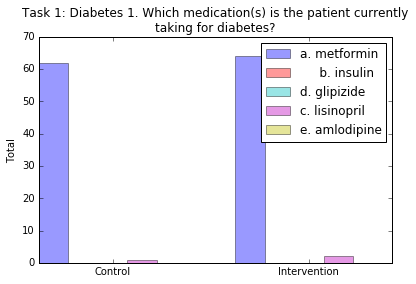

In [2]:
from utils import createBarPlot
questionsName = 'Task 1: Diabetes 1. Which medication(s) is the patient currently taking for diabetes? '
dd_number = 18
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='d2'></a>
### 2. How long has he been taking his diabetes medication(s)?
------------
*Multinomial*

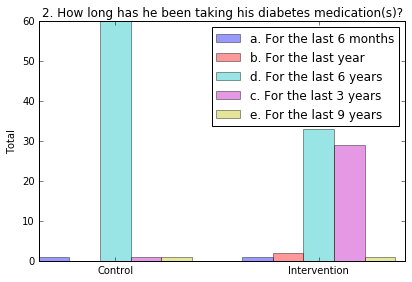

In [3]:
questionsName = '2. How long has he been taking his diabetes medication(s)?'
dd_number = 2
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='d3'></a>
### 3. Has he been compliant with his diabetes medication?
------------
*Multinomial*

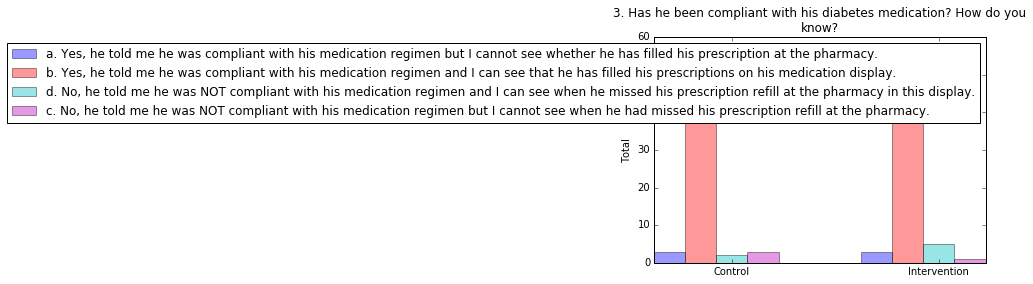

In [4]:
questionsName = '3. Has he been compliant with his diabetes medication? How do you know? '
dd_number = 5
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='d4'></a>
### 4. You ask him about his diabetes medications and you can trust
------------
*Binomial*

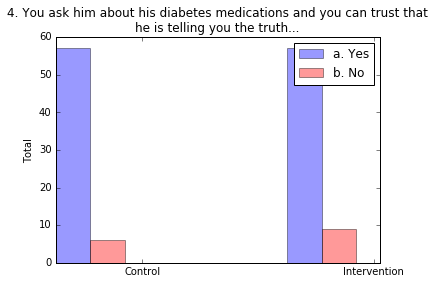

In [12]:
questionsName =  '4. You ask him about his diabetes medications and you can trust that he is telling you the truth...'
dd_number = 9
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='d5'></a>
### 5. You see that he is currently on this maximum dose. You are wondering how recently
------------
*Multinomial*

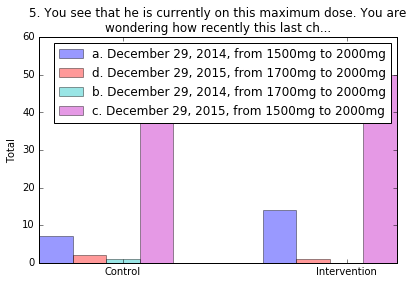

In [13]:
questionsName =  '5. You see that he is currently on this maximum dose. You are wondering how recently this last ch...'
dd_number = 13
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='d6'></a>
### 6. You realize that he has already taken the maximum dose of metformin for awhile
------------
*Multinomial*

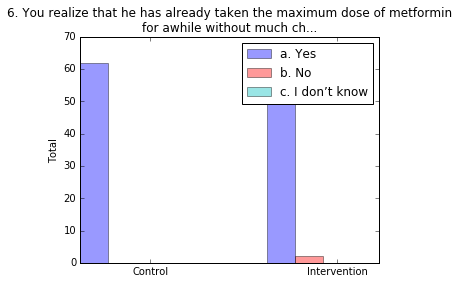

In [14]:
questionsName =  '6. You realize that he has already taken the maximum dose of metformin for awhile without much ch...'
dd_number = 14
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='d7'></a>
### 7. What was the starting dose of allopurinol prescribed for Mr. Smith?
------------
*Multinomial*

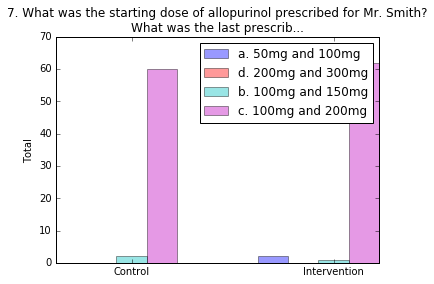

In [15]:
questionsName =  '7. What was the starting dose of allopurinol prescribed for Mr. Smith? What was the last prescrib...'
dd_number = 15
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='d8'></a>
### 8. Who prescribed his last refill of allopurinol?
------------
*Multinomial*

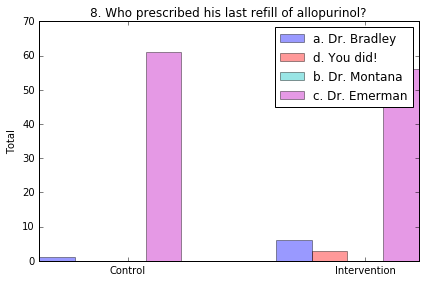

In [16]:
questionsName = '8. Who prescribed his last refill of allopurinol? '
dd_number = 16
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='d9'></a>
### 9. You see a prescription but wonder if he picked up his last prescription allopurinol.
------------
*Multinomial*

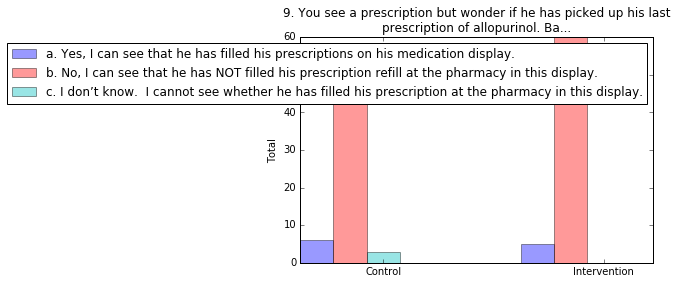

In [17]:
questionsName = '9. You see a prescription but wonder if he has picked up his last prescription of allopurinol. Ba...'
dd_number = 17
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='d10'></a>
### 10. He did not pick up his last allopurinol prescription at the pharmacy.
------------
*Multiple Choice*

<a id='d11'></a>
### 11. After asking the patient about his gout, he explains
------------
*Multinomial*

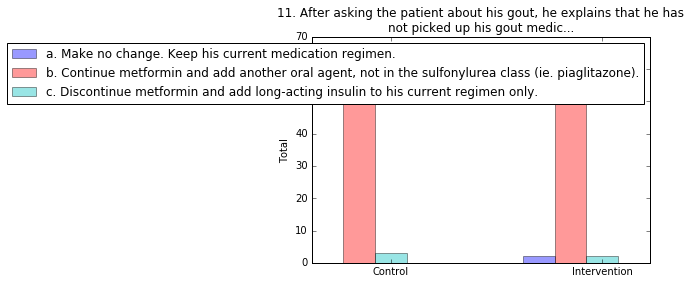

In [18]:
questionsName = '11. After asking the patient about his gout, he explains that he has not picked up his gout medic...'
dd_number = 1
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

# Hypertension
---------

<a id='h1'></a>
### 1. Mr. Smith was diagnosed with hypertension 20 years ago.
------------
*Multinomial*

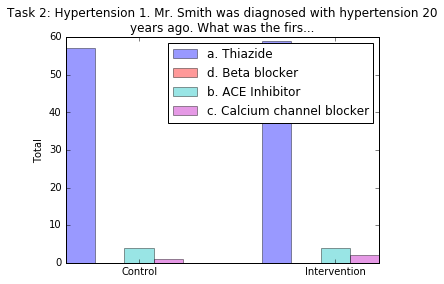

In [19]:
questionsName = 'Task 2: Hypertension 1. Mr. Smith was diagnosed with hypertension 20 years ago. What was the firs...'
dd_number = 19
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='h2'></a>
### 2. The patient’s blood pressure did not decrease in the 3 years after he
------------
*Multinomial*

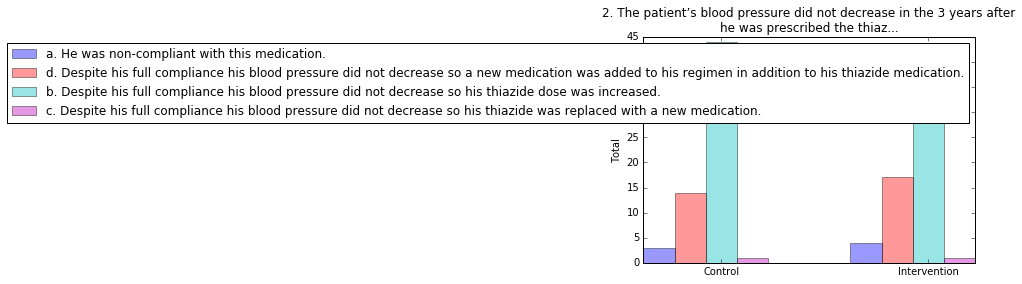

In [20]:
questionsName = '2. The patient’s blood pressure did not decrease in the 3 years after he was prescribed the thiaz...'
dd_number = 3
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='h3'></a>
### 3. Over time, Mr. Smith’s blood pressure still continued to increase
------------
*Multinomial*

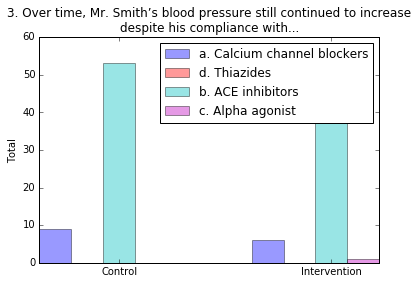

In [21]:
questionsName = '3. Over time, Mr. Smith’s blood pressure still continued to increase despite his compliance with...'
dd_number = 6
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='h4'></a>
### 4. What do you suspect happened with his new antihypertensive regimen
------------
*Multinomial*

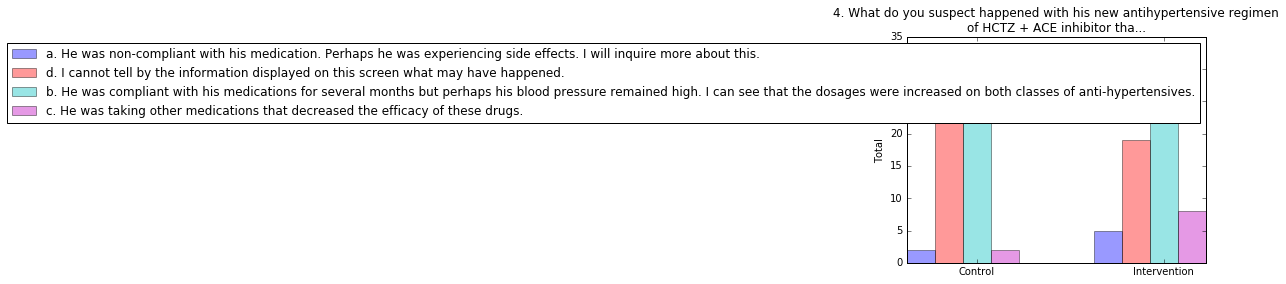

In [22]:
questionsName = '4. What do you suspect happened with his new antihypertensive regimen of HCTZ + ACE inhibitor tha...'
dd_number = 8
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='h5'></a>
### 5. Despite Mr. Smith’s diligent adherence to his exercise and diet
------------
*Multinomial*

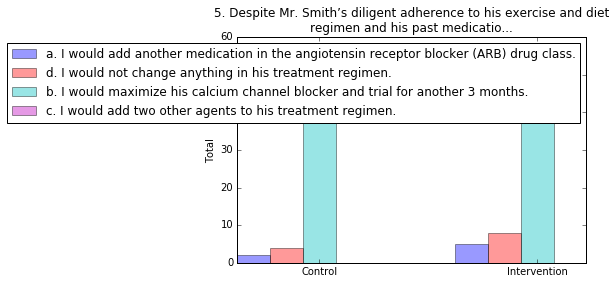

In [23]:
questionsName = '5. Despite Mr. Smith’s diligent adherence to his exercise and diet regimen and his past medicatio...'
dd_number = 11
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

# Depression
--------

<a id='de1'></a>
### 1. You continue with your check-up. The patient has
------------
*Multiple Choice*

<a id='de2'></a>
### 2. Which drugs have been escalated in dose at least twice?
------------
*Multiple Choice*

<a id='de3'></a>
### 3. You ask Mr. Smith about the details of his depression medication changes
------------
*Multinomial*

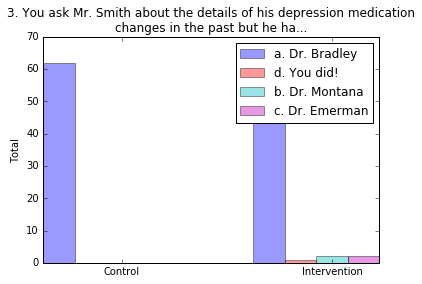

In [24]:
questionsName = '3. You ask Mr. Smith about the details of his depression medication changes in the past but he ha...'
dd_number = 7
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='de4'></a>
### 4. You’d like to know what date that provider changed the medication so you
------------
*Multinomial*

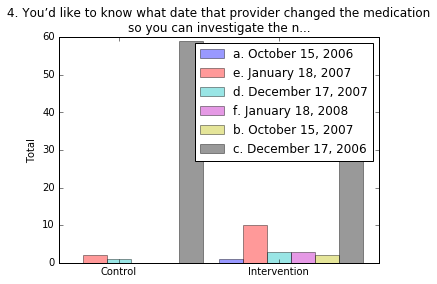

In [30]:
questionsName = '4. You’d like to know what date that provider changed the medication so you can investigate the n...'
dd_number = 10
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

<a id='de5'></a>
### 5. Why do you think the provider chose bupropion to prescribe in 2006?
------------
*Multinomial*

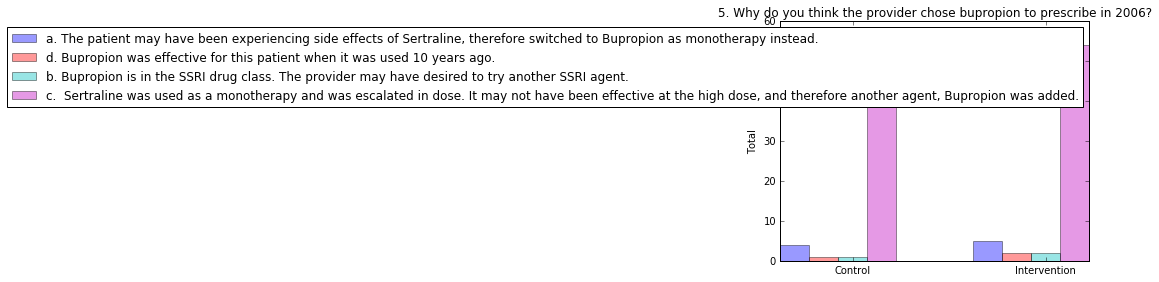

In [27]:
questionsName = '5. Why do you think the provider chose bupropion to prescribe in 2006? '
dd_number = 12
createBarPlot(questionsName,dd_number,question_choi,cq_control,cq_interve)

[Return to Main Notebook](main_med_student.ipynb)